## 네이버 영화리뷰 감성 분석

### 0) Import

In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from transformers import ElectraTokenizer

### 1) 데이터 불러오기

In [2]:
train = pd.read_table("../../dataset/nsmc_train.txt")
test = pd.read_table("../../dataset/nsmc_test.txt")

In [3]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (150000, 3) 
test shape => (50000, 3)


In [6]:
train.columns

Index(['id', 'document', 'label'], dtype='object')

### 2) 훈련 데이터 라벨링 값 비율 확인

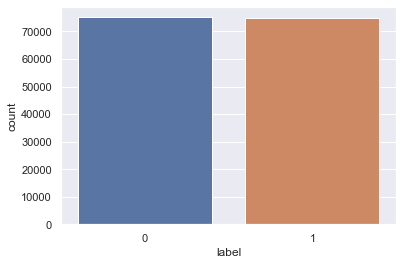

In [8]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

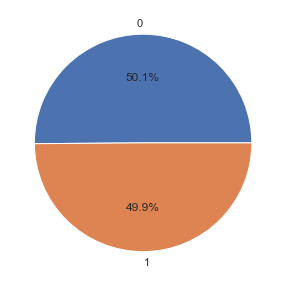

In [9]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

### 3) 훈련, 테스트 데이터 결측치 값 확인

In [11]:
train.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [12]:
test.isnull().sum()

id          0
document    3
label       0
dtype: int64

### 4) 데이터 전처리
- 데이터 중복제거(drop_duplicates)  
- 결측치 제거(dropna)  
- 한국어 토크나이저를 활용한 토큰화(pretrained KoELECTRA Tokenizer)

In [53]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

def preprocess(train, test):
    train.drop_duplicates(subset=['document'], inplace=True)
    test.drop_duplicates(subset=['document'], inplace=True)
    train = train.dropna()
    test = test.dropna()
    print(f"train shape => {train.shape} \ntest shape => {test.shape}")
    
    train_data = train['document'].values.tolist()
    test_data = test['document'].values.tolist()
    
    train_encoded = tokenizer.batch_encode_plus(train_data, padding='max_length', max_length=150)
    test_encoded = tokenizer.batch_encode_plus(test_data, padding='max_length', max_length=150)
    
    x_train, x_valid, y_train, y_valid = train_test_split(train_encoded['input_ids'], train.label.values, test_size=0.2)
    x_test = test_encoded['input_ids']
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().batch(20)
    valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).repeat().batch(20)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test)).repeat().batch(20)
    
    return train_dataset, valid_dataset, test_dataset

In [54]:
preprocess(train, test)

train shape => (146182, 3) 
test shape => (49157, 3)


(<BatchDataset shapes: ((None, 150), (None,)), types: (tf.int32, tf.int64)>,
 <BatchDataset shapes: ((None, 150), (None,)), types: (tf.int32, tf.int64)>,
 <BatchDataset shapes: (None, 150), types: tf.int32>)

In [ ]:
input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
sequence_output = encoder(input_layer)[0]

In [72]:
vocab_size = 35000
word_vector_dim = 150

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(150,)))
model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2)) 
# model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 150)          5250000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 5088      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 5,255,097
Trainable params: 5,255,097
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=valid_dataset,
                    steps_per_epoch=len(train) // 20,
                    verbose=1)

Epoch 1/20
  27/7309 [..............................] - ETA: 11:59 - loss: 0.6951 - accuracy: 0.5000

KeyboardInterrupt: 